In [2]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy.io as sio
from sklearn.model_selection import train_test_split
import random
import tifffile as tiff
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os, sys
sys.path.append('../')
# import plot

In [3]:
INDIAN_TARGET_NAMES = ['Alfalfa', 'CornMotill', 'CornMintill', 'Corn'
            , 'GrassPasture', 'GrassTrees', 'GrassPastureMowed',
                        'HayWindrowed', 'Oats', 'SoybeanNotill', 'SoybeanMintill',
                        'SoybeanClean', 'Wheat', 'Woods', 'BuildingsGrassTreesDrives',
                        'StoneSteelTowers']

PAVIA_UNIVERSITY_NAMES =  ['Asphalt','Meadows','Gravel','Trees','PaintedMetalSheets','BareSoil','Bitumen','SelfBlockingBricks','Shadows']

HOUSTION_NAMES = ['Healthy grass','Stressed grass','Synthetic grass','Trees','Soil','Water','Residential','Commercial','Road',
                  'Highway','Railway','Parking Lot 1','Parking Lot 2','Tennis Court','Running Track']
SALINAS_NAMES=['BrocoliGreenWeeds1','BrocoliGreenWeeds2','Fallow ','FallowRoughPlow','FallowSmooth',
               'Stubble','Celery','GrapesUntrained','SoilVinyardDevelop','ComSenescedGreenWeeds','LettuceRomaine4wk',
               'LettuceRomaine5wk','LettuceRomaine6wk','LettuceRomaine7wk','VinyardUntrained','VinyardVerticalTrellis']

In [4]:
class_nums = [16,9,16]
data_signs = ['IP','PU','SA']
class_sign='perclass_30'
names = [
    '1DCNN',
    '2DCNN',
    'SF',
    'miniGCN',
    'SSRN',
    'SSFTT',
    'DVML+SVM',
    'SSGRN',
    'diffusion'
]

titles=[
    'Class',
    '1D-CNN',
    '2D-CNN',
    'Spectral Former',
    'miniGCN',
    'SSRN',
    'SSFTT',
    'DMVL+SVM',
    'SSGRN',
    'Ours'
]

In [4]:
def find_path(name,dirs=None):
    for a in dirs:
        if name in a:
            return a

In [5]:
# find_path()

In [6]:
# 将each_acc转化为list
def trans_to_list(res):
    if type(res['each_acc']) == list:
        return list(np.asarray(res['each_acc']))
    ll = []
    for a in res['each_acc'].strip(' ').strip('[').strip(']').split(' '):
        try:
            nn = float(a)
            ll.append(nn)
        except:
            continue
    if len(ll) != class_num:
        print(res)
    return ll

In [7]:
list_data = []
path_prefix = '../../result/best_results/'
# list_data是二维数组，axis0是不同的算法，对应于表格中的列；axis1是每种算法下的结果，包括each_acc、OA、AA、kappa
for data_sign,class_num in zip(data_signs,class_nums):
    dirs = os.listdir('%s/%s/%s'%(path_prefix,data_sign,class_sign))
    for name in names:
        file_path = '%s/%s/%s/%s' % (path_prefix,data_sign,class_sign,find_path(name,dirs))
        print(file_path)
        res = json.loads(open(file_path).read())
        if 'eval' in res:
            res = res['eval']
        item = {}
        item['per_class'] = trans_to_list(res)
        item['oa'] = res['oa']*100 if res['oa']<1. else res['oa']
        item['aa'] = res['aa']
        item['kappa'] = res['kappa']*100 if res['kappa']<1. else res['kappa']
        list_data.append(item)

    list_data = []
    for name in names:
        file_path = '%s/%s/%s/%s' %(path_prefix, data_sign, class_sign,find_path(name,dirs))
        print(file_path)
        res = json.loads(open(file_path).read())
        if 'eval' in res:
            res = res['eval']
        item = {}
        item['per_class'] = trans_to_list(res)
        item['oa'] = res['oa']*100 if res['oa']<1. else res['oa']
        item['aa'] = res['aa']
        item['kappa'] = res['kappa']*100 if res['kappa']<1. else res['kappa']
        list_data.append(item)
    for item in list_data:
        print('%.4f' % item['oa'])


    label_names=[str(i) for i in range(1,class_num+1)]
# if data_sign=='IP':
#     label_names=INDIAN_TARGET_NAMES
# elif data_sign=='PU':
#     label_names=PAVIA_UNIVERSITY_NAMES
# elif data_sign=='SA':
#     label_names=SALINAS_NAMES


    tex_tbl='\\begin{tabular}{%s} '%('|'.join(['c']*len(titles)))
    tex_tbl+='\\toprule '
    tex_tbl+='& '.join(titles)+'\\\\ '
    tex_tbl+=' \midrule \midrule '
    for i in range(class_num):
        line=[]
        line.append(label_names[i])
        data=[]
        for item in list_data: # 读出来每一模型在第i类的分类情况.想要比较我们的是否是这一行中的最大,需要先把所有模型的结果取出来,之后比较一下
            data.append(item['per_class'][i])
        max_indices=np.argwhere(data==np.max(data))
        max_indices=max_indices.flatten().tolist()
        i=0
        for idx,d in enumerate(data):
            if i<len(max_indices) and idx==max_indices[i]:
                i+=1
                line.append('\\textbf{%.3f}'%d)
                continue
            line.append('%.2f'%d)
#         for d in data[:-1]:
#             line.append('%.3f'%d)
#         if np.argmax(data)==len(names)-1: #证明ours的数据是最高的
#             line.append('\\textbf{%.3f}'%data[-1])
#         else:
#             line.append('%.3f'%data[-1])
        tex_tbl+='& '.join(line)+'\\\\ '
    # OA AA Kappa
    tex_tbl+=' \midrule \midrule '
    for label,nominal in zip(['oa','aa','kappa'],['OA(\%)','AA(\%)','\kappa \\times 100']):
        line=[]
        line.append(nominal)
        data=[]
        for item in list_data:
            data.append(item[label])
        # 这是不论ours，客观每行的最大值加粗
        max_indices=np.argwhere(data==np.max(data))
        max_indices=max_indices.flatten().tolist()
        i=0
        for idx,d in enumerate(data):
            if i<len(max_indices) and idx==max_indices[i]:
                i+=1
                line.append('\\textbf{%.3f}'%d)
                continue
            line.append('%.2f'%d)
#         for d in data[:-1]:
#             line.append('%.3f'%d)
#         if np.argmax(data)==len(names)-1: #证明ours的数据是最高的
#             line.append('\\textbf{%.3f}'%data[-1])
#         else:
#             line.append('%.3f'%data[-1])
        tex_tbl+='&'.join(line)+'\\\\ '
    tex_tbl+=' \\bottomrule '
    tex_tbl+='\end{tabular} '
    print(tex_tbl+'\n')

../../result/best_results//IP/perclass_30/1DCNN
../../result/best_results//IP/perclass_30/2DCNN
../../result/best_results//IP/perclass_30/SF
../../result/best_results//IP/perclass_30/miniGCN
../../result/best_results//IP/perclass_30/SSRN
../../result/best_results//IP/perclass_30/SSFTT
../../result/best_results//IP/perclass_30/DVML+SVM
../../result/best_results//IP/perclass_30/SSGRN
../../result/best_results//IP/perclass_30/diffusion
../../result/best_results//IP/perclass_30/1DCNN
../../result/best_results//IP/perclass_30/2DCNN
../../result/best_results//IP/perclass_30/SF
../../result/best_results//IP/perclass_30/miniGCN
../../result/best_results//IP/perclass_30/SSRN
../../result/best_results//IP/perclass_30/SSFTT
../../result/best_results//IP/perclass_30/DVML+SVM
../../result/best_results//IP/perclass_30/SSGRN
../../result/best_results//IP/perclass_30/diffusion
66.0071
66.9658
67.7817
63.9164
90.6578
91.5655
90.4869
92.3359
93.1464
\begin{tabular}{c|c|c|c|c|c|c|c|c|c} \toprule Class& 1

In [8]:
# 开始画数据集的描述的表格
data_prefix = '../../data/'
def load_train_test(sign, num, names):
    dataset_path = '%s/%s/%s_%s_split.mat' % (data_prefix, sign, sign, num)
    class_num = len(names)
    datamat = sio.loadmat(dataset_path)
    data = datamat['input']
    TE = datamat['TE'].reshape(-1)
    TR = datamat['TR'].reshape(-1)
    train = []
    test = []
    for i in range(class_num):
        c = i + 1
        train.append(TR[TR==c].size)
        test.append(TE[TE==c].size)
    return train, test

In [9]:
info = {}
signs = ['Indian', 'Pavia', 'Salinas']
num = 30
names = [INDIAN_TARGET_NAMES, PAVIA_UNIVERSITY_NAMES, SALINAS_NAMES]
for sign, name in zip(signs, names):
    train, test = load_train_test(sign, num, name)
    info[sign] = {
        'name':name,
        'train':train,
        'test':test
    }

In [10]:
max_index = 16

ss_list = []
for i in range(max_index):
    ll = []
    ss = ""
    c = i + 1
    ll.append(str(c))
    for sign in signs:
        if len(info[sign]['name']) > i:
            ll.append(info[sign]['name'][i])
            ll.append(info[sign]['train'][i])
            ll.append(info[sign]['test'][i])
        else:
            ll.append(' ')
            ll.append(' ')
            ll.append(' ')
    ss = '  &  '.join([str(a) for a in ll])
    ss_list.append(ss)
    
    
#total
ll = [' ']
for sign in signs:
    ll.append('Total')
    ll.append(sum(info[sign]['train']))
    ll.append(sum(info[sign]['test']))
ss = '  &  '.join([str(a) for a in ll])
ss_list.append(ss)
    
print('  \\\\  '.join(ss_list))

1  &  Alfalfa  &  30  &  16  &  Asphalt  &  30  &  6601  &  BrocoliGreenWeeds1  &  30  &  1979  \\  2  &  CornMotill  &  30  &  1398  &  Meadows  &  30  &  18619  &  BrocoliGreenWeeds2  &  30  &  3696  \\  3  &  CornMintill  &  30  &  800  &  Gravel  &  30  &  2069  &  Fallow   &  30  &  1946  \\  4  &  Corn  &  30  &  207  &  Trees  &  30  &  3034  &  FallowRoughPlow  &  30  &  1364  \\  5  &  GrassPasture  &  30  &  453  &  PaintedMetalSheets  &  30  &  1315  &  FallowSmooth  &  30  &  2648  \\  6  &  GrassTrees  &  30  &  700  &  BareSoil  &  30  &  4999  &  Stubble  &  30  &  3929  \\  7  &  GrassPastureMowed  &  14  &  14  &  Bitumen  &  30  &  1300  &  Celery  &  30  &  3549  \\  8  &  HayWindrowed  &  30  &  448  &  SelfBlockingBricks  &  30  &  3652  &  GrapesUntrained  &  30  &  11241  \\  9  &  Oats  &  10  &  10  &  Shadows  &  30  &  917  &  SoilVinyardDevelop  &  30  &  6173  \\  10  &  SoybeanNotill  &  30  &  942  &     &     &     &  ComSenescedGreenWeeds  &  30  &  324

In [11]:
#画diffusion论文的raw feature与diffuion对比
def one_line(sign, per_class, name):
    path_prefix = '../../result/best_results/'
    path = '%s/%s/perclass_%s/%s' % (path_prefix, sign, per_class, name)
    with open(path, 'r') as fin:
        js = json.loads(fin.read())
        eval_info = js['eval']
        ss = ' & '.join(['%.2f' % float(s) for s in [eval_info['oa'], eval_info['aa'], eval_info['kappa']]])
        print('%s_%s  &%s' %(sign, name, ss))
        
for sign in ['IP', 'PU', 'SA']:
    for name in ['transformer', 'diffusion']:
        one_line(sign, 30, name)

IP_transformer  &92.37 & 95.61 & 91.27
IP_diffusion  &93.15 & 96.44 & 92.17
PU_transformer  &88.91 & 89.77 & 85.51
PU_diffusion  &94.77 & 93.84 & 93.06
SA_transformer  &95.80 & 98.26 & 95.34
SA_diffusion  &98.97 & 99.47 & 98.85


[94.11328725749968, 95.24428998866361, 95.80420883893456, 97.67428817139972, 97.50604736634851, 98.03268822057966, 98.63230772133033, 98.5865390073606]
[93.2961514943764, 97.21422066940475, 98.97108986188, 98.74179737890033, 99.02679592716909, 99.04831762869341, 99.52838197287252, 99.49857140154023]


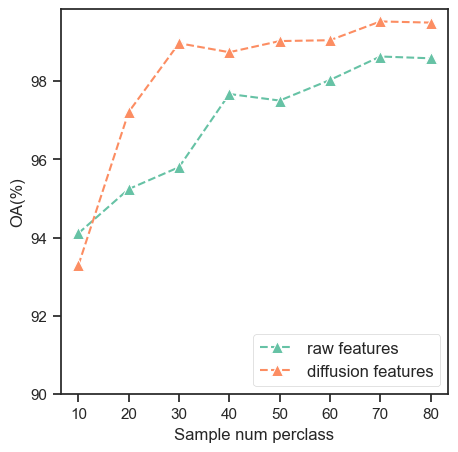

In [14]:
sign = 'SA'
name = 'diffusion'
tt = 'oa'
def cat_eval_info(sign, name, tt):
    path_prefix = '../../result/best_results/'
    res = []
    for num in range(10, 81, 10):
        path = '%s/%s/perclass_%s/%s' % (path_prefix, sign, num, name)
        with open(path, 'r') as fin:
            js = json.loads(fin.read())
            v = float(js['eval']['oa'])
            if v < 1:
                res.append(100 * v)
            else:
                res.append(v)
    return res

            
names = [
#     '1DCNN',
#     '2DCNN',
#     'SF',
#     'miniGCN',
#     'SSRN',
#     'SSFTT',
#     'DVML+SVM',
#     'SSGRN',
    'transformer',
    'diffusion'
]

titles=[
#     '1D-CNN',
#     '2D-CNN',
#     'Spectral Former',
#     'miniGCN',
#     'SSRN',
#     'SSFTT',
#     'DMVL+SVM',
#     'SSGRN',
    "raw features",
#     'ours',
    'diffusion features'
]

nums = list(range(10,81,10))
sns.set_theme(style="ticks", palette="Set2")
# sns.set(rc={'figure.figsize':(5, 5)})
fig, ax = plt.subplots()
for i in range(len(names)):
    name = names[i]
    title = titles[i]
    res = cat_eval_info(sign, name, tt)
    print(res)
    sns.lineplot(x=nums, y=res,marker="^", markersize=8, linestyle="--",label=title)

ax.set_xlabel("Sample num perclass")
ax.set_ylabel("OA(%)")

yticks = list(range(90,100,2))
ax.set_yticks(yticks)
# 设置图例位置和大小
legend = ax.legend(loc="lower right", prop={"size": 12})

# 调整图例框架的大小
frame = legend.get_frame()
frame.set_linewidth(0.5)
plt.show()

In [13]:
# 生成ablation study图
path = '../../result/res_diffusion_t_layer/'
list_layer = []
list_t = []
list_oa = []
list_aa = []
list_kappa = []
signs = []
for p in os.listdir(path):
    items = p.split('_')
    sign = items[0]
    t = items[2]
    layer = items[3]
    ss = json.loads(open('%s/%s' %(path, p), 'r').read())
    ev = ss['eval']
    oa, aa, kappa = ev['oa'], ev['aa'], ev['kappa']
    signs.append(sign)
    list_layer.append(layer)
    list_t.append(t)
    list_oa.append(oa)
    list_aa.append(aa)
    list_kappa.append(kappa)
df = pd.DataFrame({'sign':signs, 'layer':list_layer, 't': list_t, 'oa': list_oa, 'aa':list_aa, 'kappa': list_kappa})
print(oa, aa, kappa)

98.02233033234543 99.03045833150048 97.79874609868608


In [14]:
for layer in [0, 1, 2]:
    for t in [5, 10, 50, 100, 200]:
        ss = [layer, t]
        for s in ['indian', 'pavia', 'salinas']:
            df_temp = df[(df['sign']==s)&(df['layer']==str(layer))&(df['t']==str(t))]
            ss.append('%.2f' % df_temp['oa'].values[0])
            ss.append('%.2f' % df_temp['aa'].values[0])
            ss.append('%.2f' %df_temp['kappa'].values[0])
            res = ' & '.join([str(s) for s in ss])
        print(' %s \\\\' %(res))

 0 & 5 & 92.73 & 95.96 & 91.69 & 94.49 & 93.11 & 92.62 & 98.97 & 99.47 & 98.85 \\
 0 & 10 & 92.19 & 96.08 & 91.08 & 93.60 & 93.14 & 91.57 & 98.64 & 99.35 & 98.49 \\
 0 & 50 & 92.67 & 96.10 & 91.62 & 93.48 & 91.79 & 91.37 & 97.73 & 99.05 & 97.47 \\
 0 & 100 & 92.43 & 95.93 & 91.35 & 92.86 & 92.04 & 90.53 & 97.80 & 98.87 & 97.56 \\
 0 & 200 & 91.39 & 95.56 & 90.18 & 91.62 & 90.84 & 88.96 & 97.70 & 98.72 & 97.44 \\
 1 & 5 & 92.97 & 96.43 & 91.98 & 94.31 & 94.19 & 92.53 & 98.69 & 99.22 & 98.54 \\
 1 & 10 & 92.41 & 96.11 & 91.34 & 94.72 & 93.83 & 93.00 & 98.32 & 99.20 & 98.13 \\
 1 & 50 & 91.90 & 95.92 & 90.75 & 92.73 & 93.03 & 90.46 & 97.99 & 98.94 & 97.76 \\
 1 & 100 & 92.12 & 95.80 & 90.99 & 94.12 & 92.79 & 92.19 & 97.98 & 99.08 & 97.75 \\
 1 & 200 & 92.02 & 95.89 & 90.89 & 91.84 & 90.55 & 89.27 & 96.73 & 98.42 & 96.36 \\
 2 & 5 & 92.72 & 96.19 & 91.69 & 92.02 & 91.65 & 89.52 & 98.02 & 99.03 & 97.80 \\
 2 & 10 & 92.85 & 96.39 & 91.84 & 91.26 & 91.02 & 88.55 & 97.74 & 98.77 & 97.49 \\
 2 

In [15]:
sss = '''CNN1D	974	3794	2001
CNN2D	1465	4584	2474
SF	2981	16334	14130
miniGCN	95	240	213
SSRN	4802	24806	22280
SSFTT	3158	11008	5596
SMVL	3160	10848	16870
SSGRN	113	499	298
Ours	4853	25623	24216
'''

def tofloatorstr(item):
    try:
        a = float(item)
        return '%.2f' %(a * 0.01)
    except Exception as e:
        return item
lines = sss.split('\n')
for line in lines:
    items = line.split('\t')
    print(' & '.join([tofloatorstr(s) for s in items]) + ' \\\\')
        

CNN1D & 9.74 & 37.94 & 20.01 \\
CNN2D & 14.65 & 45.84 & 24.74 \\
SF & 29.81 & 163.34 & 141.30 \\
miniGCN & 0.95 & 2.40 & 2.13 \\
SSRN & 48.02 & 248.06 & 222.80 \\
SSFTT & 31.58 & 110.08 & 55.96 \\
SMVL & 31.60 & 108.48 & 168.70 \\
SSGRN & 1.13 & 4.99 & 2.98 \\
Ours & 48.53 & 256.23 & 242.16 \\
 \\
